# Review of Finance cleaning

In [1]:
from tokenize import Ignore
from numpy import NaN
import numpy as np
import pandas as pd
from difflib import SequenceMatcher
import time
from os import path
import os
from pathlib import Path
from PyPDF2 import PdfFileReader, PdfFileWriter
import re
import matplotlib.pyplot as plt 
import math

### Read in data

In [2]:
masters = pd.read_excel(Path("D:/docs/Masters/Data/Extra/revifinastud_master.xlsx"))
pivots = pd.read_excel(Path("D:/docs/Masters/Data/Extra/revifinastud_pivots.xlsx"))

pd.set_option('display.max_colwidth', None)

In [4]:
saveas=Path("D:/docs/Masters/Data/Extra/revifinastud_processed.xlsx")


### Initial data exploration

In [3]:
masters.columns

Index(['type', 'issue_url', 'ISSN', 'URL', 'journal', 'number', 'publisher',
       'title', 'urldate', 'volume', 'year', 'abstract', 'author', 'pages',
       'reviewed-author'],
      dtype='object')

In [4]:
pd.set_option('display.max_rows',masters.shape[0])
temp=masters['title'].str.lower().value_counts()
pd.DataFrame(temp)

,title
front matter,210
back matter,209
volume information,17
erratum,9
corrigendum,6
a note from the editor,3
do foreigners invest less in poorly governed firms?,2
returns to shareholder activism: evidence from a clinical study of the hermes uk focus fund,2
competition and cooperation in divisible good auctions: an experimental examination,1
explaining returns with cash-flow proxies,1


In [5]:
temp2=masters[(masters['author'].isna()==True)]['title'].str.lower().value_counts()
pd.DataFrame(temp2)

,title
front matter,210
back matter,209
volume information,17
erratum,9
corrigendum,6
corrigendum: information content of a nonlinear macro-finance model for commodity prices,1
"errata to harford, de angelis and cole",1
in memoriam: rick green,1
erratum: does public financial news resolve asymmetric information?,1
erratum: managerial incentives and the role of advisors in the continuous-time agency model,1


### Initial classification

From above, anything with greater than or equal to 17 duplicates are miscellaneous content. This can be classified in bulk.

Similarly, any article with a non-empty review-author field is easily classified as a review. This is because of the bibtex formatting.

In [6]:
#Remove the bulk of the miscellaneous content 
removal=list(temp[temp>=17].index)
masters.loc[masters.title.str.lower().isin(removal),'content_type']='MISC'

#Set the reviews, reviewed-author will not be null for reviewed works
masters.loc[(masters['reviewed-author'].isna()==False), 'content_type']='Review'

Classifying individual cases because these are highly likely to be miscellaneous but also have authors so we cannot blanket classify anything that does have an author as an article. Errata/erratum articles are also classified separately here.

In [7]:
masters.loc[masters['title'].str.lower().str.match(r'^errat(a*|um*|tum*|ta*)')==True, 'content_type']='Errata'
masters.loc[masters['title'].str.lower().str.contains('corrigendum')==True, 'content_type']='Corrigendum'
masters.loc[masters['title'].str.lower().str.contains('in memoriam:')==True, 'content_type']='MISC'
masters.loc[masters['title'].str.lower().str.contains('note from the editor')==True, 'content_type']='MISC'

In [16]:
#masters[masters['title'].str.lower().str.match(r'^in memoriam:*')==True]
#masters[masters['title'].str.lower().str.contains('corrigendum')==True]

### Discussions

In [8]:
masters.loc[(masters['title'].str.lower().str.contains('discussion')==True), 'content_type']='Discussions'

### Replies

In [9]:
masters.loc[(masters['title'].str.lower().str.match(r'.*a reply')==True),'content_type']='Reply'

### Comment

In [10]:
masters.loc[(masters['title'].str.lower().str.match(r'.*comment(|s)')==True),'content_type']='Comment'

### Articles

In [11]:
masters.loc[(masters['content_type'].isna()==True),'content_type']='Article'

### Saving ...

In [25]:
masters.to_excel(saveas, index=False)

## Exploratory statistics
### Summary

In [12]:
masters.content_type.value_counts()

Article        1844
MISC            440
Review           22
Errata           17
Discussions       9
Corrigendum       7
Comment           1
Name: content_type, dtype: int64

### Author counts

In [13]:
check_data=pd.DataFrame()
for i in masters.index:
    if ((masters.iloc[i]['content_type']!='MISC') & (masters.iloc[i]['content_type']!='Review')& ( pd.isnull(masters.iloc[i]['author'])!=True)):
    #if ((masters.iloc[i]['content_type']=='Article')& ( pd.isnull(masters.iloc[i]['author'])!=True)):
        authors=[]
        presplit=masters.iloc[i]['author'].split(' and ')
        for a in presplit:
            if a.__contains__('Jr.') or a.__contains__('Jr'):
                #print('found junior')
                #print(a)
                
                authors=np.concatenate((authors,[a.replace(', Jr.',' Jr.')]))
            else:
                authors=np.concatenate((authors,a.split(', ')))
        #print('_'.join(list(authors))+" "+str(len(authors)) + str(Merged.iloc[i]['year']))
        
        check_data=pd.concat([check_data, 
                              pd.DataFrame(
                                  [{'pdf_url': masters.iloc[i]['URL'],
                                    'authors':'\''+'_'.join(list(authors))+'\'', 
                                    'num_auth':len(authors),
                                    'year':masters.iloc[i]['year']
                                   }]
                              )], 
                             ignore_index=True)
        

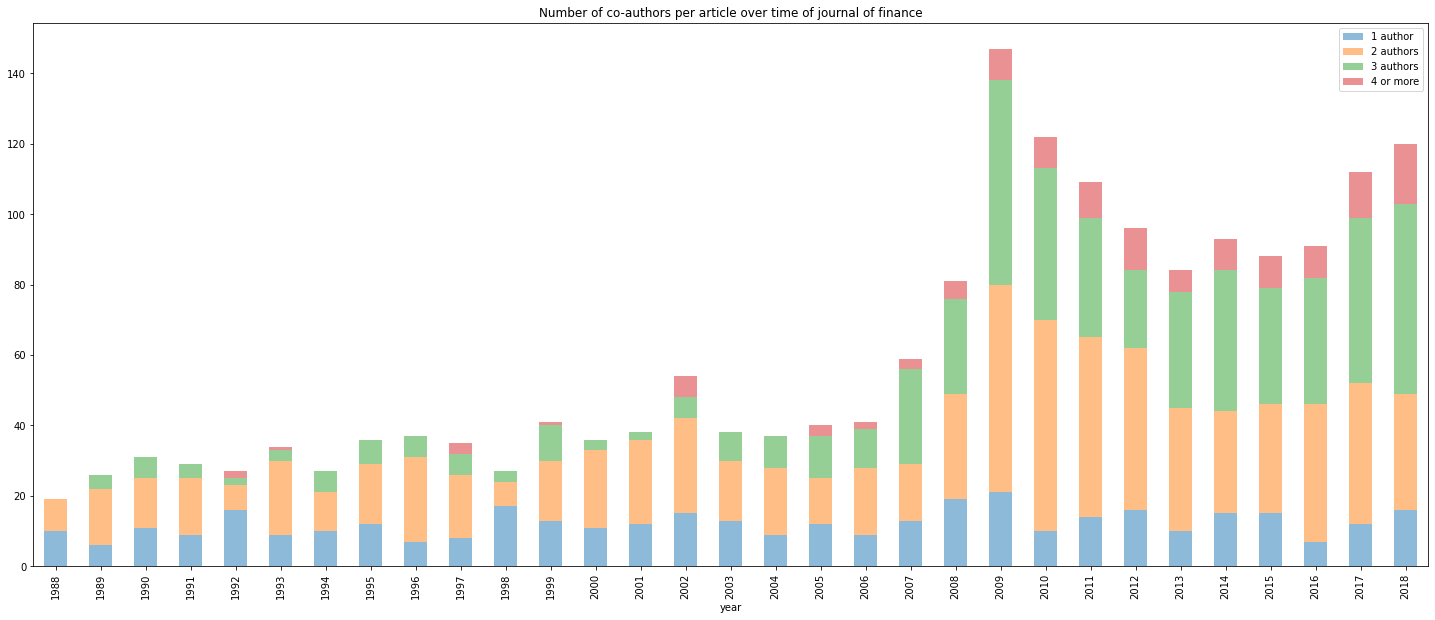

In [15]:
plt.rcParams["figure.figsize"] = (25, 10)
tmp=pd.DataFrame()
tmp['1 author']=check_data[check_data['num_auth']==1]['year'].value_counts()
tmp['2 authors']=check_data[check_data['num_auth']==2]['year'].value_counts()
tmp['3 authors']=check_data[check_data['num_auth']==3]['year'].value_counts()
tmp['4 or more']=check_data[check_data['num_auth']>3]['year'].value_counts()

tmp=tmp.reset_index()
tmp=tmp.sort_values(by='index')

ax=tmp.plot.bar(x='index', 
                stacked=True, 
                title='Number of co-authors per article over time of journal of finance',
                alpha=0.5, 
                legend=True, 
                xlabel='year')


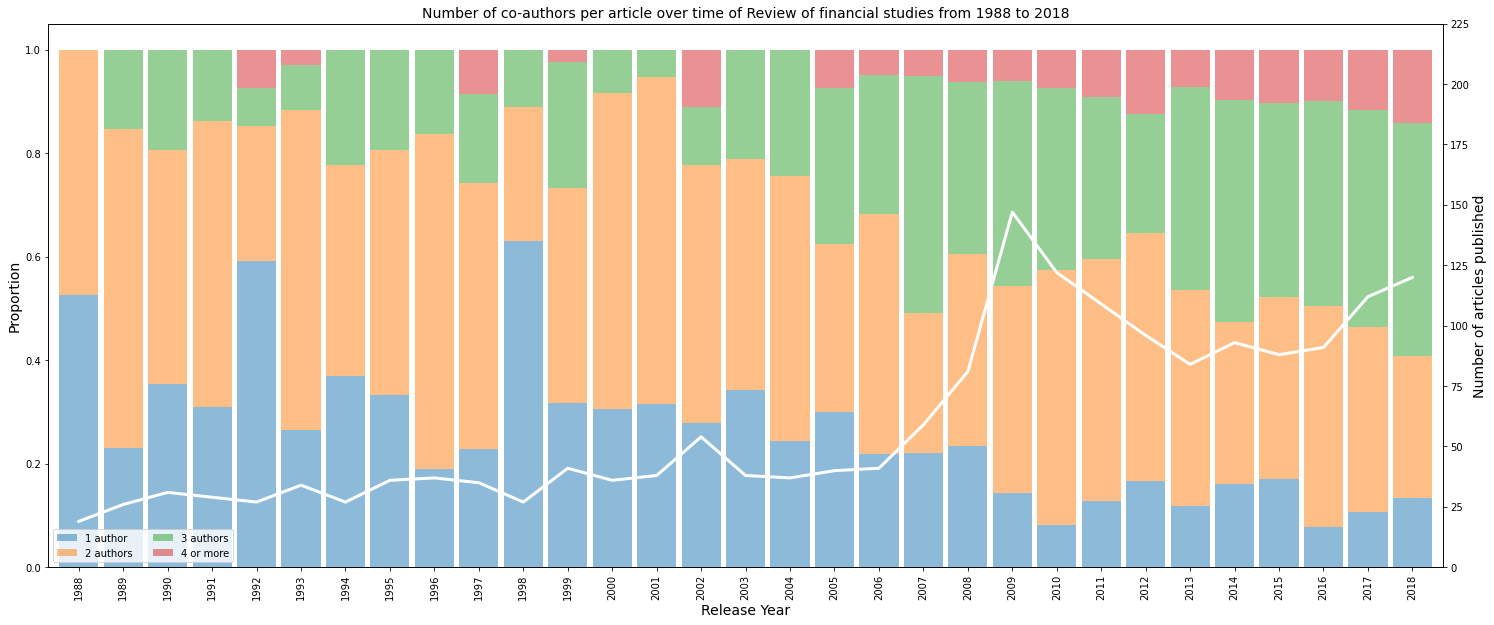

In [31]:
plt.rcParams["figure.figsize"] = (25, 10)
tmp2=pd.DataFrame()
norm=check_data['year'].value_counts()
total=norm
tmp2['1 author']=check_data[check_data['num_auth']==1]['year'].value_counts()/norm
tmp2['2 authors']=check_data[check_data['num_auth']==2]['year'].value_counts()/norm
tmp2['3 authors']=check_data[check_data['num_auth']==3]['year'].value_counts()/norm
tmp2['4 or more']=check_data[check_data['num_auth']>3]['year'].value_counts()/norm

tmp2=tmp2.reset_index()
tmp2=tmp2.sort_values(by='index')

total=pd.DataFrame(total)
ax1=tmp2.plot.bar(x='index', 
                  stacked=True, 
                  alpha=0.5, 
                  legend=True, 
                  xlabel='year', 
                  width=0.88,
                  xlim=(1974,2022)
                 )
#ax1.set_facecolor('black')

plt.legend(loc="lower left", ncol=2)
plt.xlabel("Release Year", size=14)
plt.ylabel("Proportion", size=14)
plt.title('Number of co-authors per article over time of Review of financial studies from 1988 to 2018', size=14)
ax2=ax1.twinx()
total.sort_index().plot(use_index=False, ax=ax2, color='white', linewidth=3)
ax2.get_legend().remove()
ax2.set_ylabel("Number of articles published", size=14)

ax1.plot( use_index=False, ax=ax1, color='red', linewidth=1)  
#plt.grid(True)
ax2.set_ylim(0,225)
plt.show()
